# k-Nearest Neighbor (kNN) exercise

KNN分类器包含两个阶段
- 训练期间，分类器使用所有的训练数据，只是读取并存入到一个变量中
- 测试期间，KNN分类器通过比较所有图像和测试图像，把训练样本中与测试样本最相近的K个图像的标签赋给测试图像
- K值经过交叉验证选择

本次练习需要你实现上述步骤，理解基本的图像分类流程、交叉验证，以及获取编写高效的向量化代码的能力

利用软链接，将utils文件夹的快捷方式映射到Assignment1文件夹中，方便调用

```bash
# ln -s XXXX/utils  XXXX/Assignment1
# 在`XXXX/Assignment1`文件夹中建立`XXXX/utils`的快捷方式
ln -s ../utils ../Assignment1
```
只需要执行一次即可

In [2]:
!ln -s ../utils ../Assignment1

ln: ../Assignment1/utils: File exists


In [3]:
import random
import numpy as np
from utils.datasets_util import get_CIFAR10_data,load_cifar10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

#__init__.py https://zhuanlan.zhihu.com/p/474874811

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [4]:
# Load the raw CIFAR-10 data.
cifar10_dir = '../../datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_cifar10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


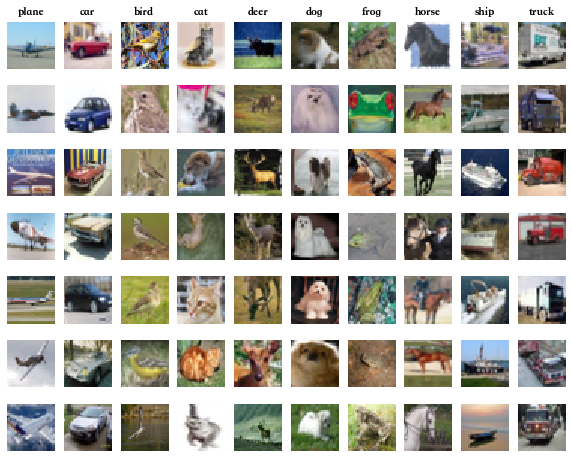

In [5]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [6]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
X_train = X_train[:num_training].astype(float) # 数据类型调整之后，就没有出错了
y_train = y_train[:num_training]
# mask = list(range(num_training))
# X_train = X_train[mask]
# y_train = y_train[mask]

num_test = 500
X_test = X_test[:num_test].astype(float)
y_test = y_test[:num_test]
# mask = list(range(num_test))
# X_test = X_test[mask]
# y_test = y_test[mask]

In [7]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [8]:
from utils.classifiers import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

接下来会使用KNN分类器对测试数据进行分类，回想一下之前KNN分类器的内容，其处理过程可以分为两步：
1. 首先计算每个测试样本和所有训练样本的距离
2. 计算出距离后，对于每个测试样本，找到距离其最近的K个训练样本，使用投票的方式，把K个训练样本中出现次数最多的label分配给训练样本

从计算所有训练样本和每个测试样本的距离矩阵开始（用numpy向量化操作来批量处理），例如：
+ 有$N_{tr}$个训练样本，以及$N_{te}$个测试样本，则对于第一阶段，会得到一个$N_{te}\times N_{tr}$的距离矩阵，其中$N_{i,j}$表示第$i$个测试样本和第$j$个训练样本的距离
+ 接下来，开始实现第一步，在文件`utils/classifiers/k_nearest_neighbor.py`中，实现`compute_distances_two_loops`函数(使用两层for训练来进行距离的计算，每次只计算一对测试样本和训练样本的距离，是一种比较低效的实现)

In [9]:
# Open utils/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


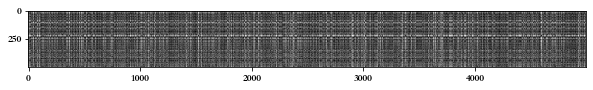

In [10]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.figure()
plt.imshow(dists, interpolation='none')
plt.show()

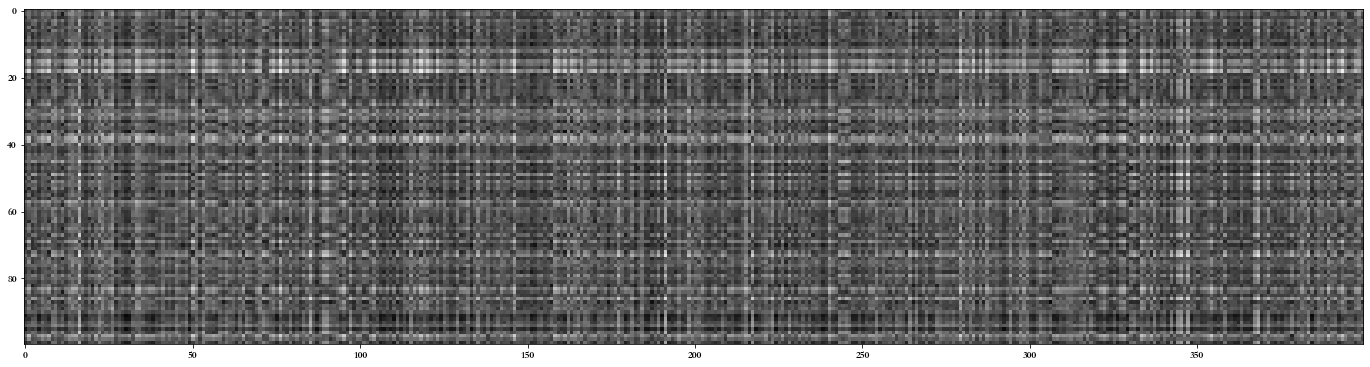

In [11]:
plt.figure(figsize=(24,20))
plt.imshow(dists[200:300,800:1200], interpolation='none')
plt.show()

**问题1**：可以看到在上面的距离矩阵中，有些行或者列明显更亮（使用默认的颜色模式显示时，黑色表示距离近（计算出的距离值小），白色表示距离远（计算出的距离值大））
+ 造成数据中明显很亮的行的原因是什么？
+ 列很亮的原因是什么？

**解答**：(为了看的更仔细，可以缩放一下要查看的数据范围)
+ 行很亮，说明这一行的距离值都很大，说明对于这个测试样本来说，和5000个训练样本都不是很相近，也能说明，这个测试样本所属于的类别，在5000个训练样本中很少（训练样本类别不平衡）
+ 同理，则列很亮说明测试集中和当前训练集样本的列的标签相同的很少，即测试集类别不平衡。
+ 不然不会出现某些行/列明显亮于其他行/列，说明这个类别在训练集/测试集中很少，才导致相比之下，距离远的值占多数，显得很亮

In [12]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)
print(f"y_test_pred check value: {y_test_pred[:10]}")

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

y_test_pred check value: [4 9 8 8 4 4 3 2 5 8]
Got 137 / 500 correct => accuracy: 0.274000


你会得到一个`27%`左右的准确率，现在试试用一个更大的`k`，比如`k=5`

In [13]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


你会看到一个比`k=1`好点的性能，有些`k>1`的取值反而会降低准确率，可以试试

In [14]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [15]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)
# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [16]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# you should see significantly faster performance with the fully vectorized implementation

Two loop version took 23.701186 seconds
One loop version took 40.536596 seconds
No loop version took 0.203502 seconds


所以就很奇怪，为什么`one loop`还比`two loop`慢，
+ 说明行读取比单个元素读取要慢，可能和存储方式的行优先/列优先相关吧

### Cross-validation

截止到目前，已经实现了KNN，但是是任意设置了K=5，因此可以通过交叉验证来找到最优的超参数K

In [17]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
X_train_folds = np.array_split(X_train,num_folds)
y_train_folds = np.array_split(y_train,num_folds)

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
for k in k_choices:
    acc_list = []
    for i in range(num_folds):
        X_val = X_train_folds[i]
        y_val = y_train_folds[i]

        X_train_iFold = np.concatenate(X_train_folds[:i]+X_train_folds[i+1:])
        y_train_iFold = np.concatenate(y_train_folds[:i]+y_train_folds[i+1:])
        
        # print(X_val.shape,y_val.shape)
        classifier.train(X_train_iFold, y_train_iFold)
        dists = classifier.compute_distances_no_loops(X_val)
        y_pred_label = classifier.predict_labels(dists,k)
        # print(y_pred_label.shape)
        num_correct = np.sum(np.equal(y_pred_label,y_val))
        accuracy = num_correct/y_val.shape[0]
        # print(num_correct,y_val.shape[0])
        acc_list.append(accuracy)

    k_to_accuracies[k]=acc_list

# Print out the computed accuracies
# 直接sorted，会得到key的列表
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.276000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k = 12, accuracy = 0.295000
k = 12, accuracy = 0.279000
k = 12, accuracy = 0.283000
k = 12, accuracy = 0.280000
k = 15, accuracy = 0.252000
k = 15, accuracy = 0.289000
k = 15, accuracy = 0.278000
k = 15, accuracy = 0.282000
k = 15, accuracy = 0.274000
k = 20, accuracy = 0.270000
k = 20, accu

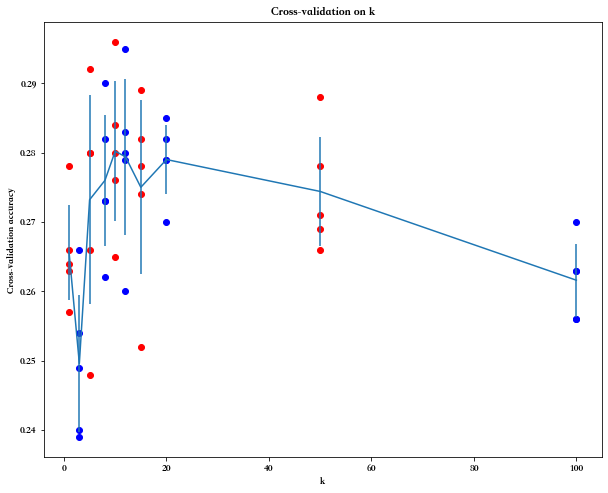

In [34]:
# plot the raw observations
color_list = ['red','blue']*5
for i,k in enumerate(k_choices):
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies,c=color_list[i]) # 竖列的点

# 使用误差棒来绘制标准差的趋势线
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
# https://stackoverflow.com/questions/41892680/how-can-i-specify-the-discrete-values-that-i-want-to-plot-on-the-x-axis-matplot
plt.show()

```python
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]
```
从上图可以看出，`K=10`有最高的准确率，同时方差也不是很大

In [32]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000


你可以得到的最优测试准确率是28%

## 测试代码（读入数据数据类型uint8，满足不了方差等计算时平方的数据范围，改为float即可）

所以现在就明白，为什么在原始的Assignment1中的读取cifar10的函数里，使用的是float类型

In [20]:
# 测试channel mean和std的计算及normalize实现
import numpy as np
a = np.array([[[1,2,3,4,5],[6,7,8,9,10]],[[1,2,3,5,5],[6,7,8,8,10]],[[1,5,3,4,5],[6,7,10,9,10]]])
print(a.shape)
mean = np.mean(a,axis=(1,2),keepdims=True)
print(mean.shape)
print(mean)
print(np.subtract(a,mean))

(3, 2, 5)
(3, 1, 1)
[[[5.5]]

 [[5.5]]

 [[6. ]]]
[[[-4.5 -3.5 -2.5 -1.5 -0.5]
  [ 0.5  1.5  2.5  3.5  4.5]]

 [[-4.5 -3.5 -2.5 -0.5 -0.5]
  [ 0.5  1.5  2.5  2.5  4.5]]

 [[-5.  -1.  -3.  -2.  -1. ]
  [ 0.   1.   4.   3.   4. ]]]


In [21]:
# 检查norm计算L2距离时，广播机制的情况
a=np.array([[1,2],[3,4],[3,3]])
b= np.array([[1,1],[0,1]])
rs=np.zeros((3,2))
# print(np.linalg.norm(a-b[0],axis=1,keepdims=True)) # 单重循环要写axis=1
# print(np.linalg.norm(a-b[1],axis=1,keepdims=True)) 
# print(np.linalg.norm(np.array([3,4])-np.array([1,1]))) # 只有axis=0，没有axis=1，双重循环里没写

# 双重循环
for i in range(3):
    for j in range(2):
        rs[i,j]=np.linalg.norm(a[i]-b[j]) #test -train # 这里加不加keepdims=True结果一样
print("双重循环")
print(rs)

# 单循环
rs=np.zeros((3,2))
for i in range(3):
    rs[i]=np.linalg.norm(a[i]-b,axis=1) #test -train # 单循环不能加keepdims=True
print("单循环")
print(rs)

# https://numpy.org/doc/stable/user/basics.broadcasting.html#a-practical-example-vector-quantization
# Observation      (2d array):      10 x 3
# Codes            (3d array):   5 x 1 x 3
# Diff             (3d array):  5 x 10 x 3
# Diff = Codes - Observation
# Diff(500X5000) = Test(500X1X3072) - Train(50000X3072)
a = np.array([[1,2],[3,4],[3,3]]) 
a= a[:,np.newaxis,:] # a.shape (3, 1, 2)
b= np.array([[1,1],[0,1]]) # b.shape (2, 2)
rs = np.linalg.norm(a-b,axis=2) # 注意，这里添加了一个轴，所以axis=2
print(f"没有循环,使用广播机制的方法1")
print(rs)  
# np.transpose(np.linalg.norm(a-b,axis=1))

# https://stackoverflow.com/questions/64952027/compute-l2-distance-with-numpy-using-matrix-multiplication #
# X = X[:, np.newaxis, :]
# dists = np.linalg.norm(X-self.X_train,axis=1)
# 这样写内存会爆炸。。  500x5000x3072=76.8亿  数值是uint8类型，1byte
# 500x5000x3072/1024/1024/1024=7.15GB.... 这个数量级略可怕

双重循环
[[1.         1.41421356]
 [3.60555128 4.24264069]
 [2.82842712 3.60555128]]
单循环
[[1.         1.41421356]
 [3.60555128 4.24264069]
 [2.82842712 3.60555128]]
没有循环,使用广播机制的方法1
[[1.         1.41421356]
 [3.60555128 4.24264069]
 [2.82842712 3.60555128]]


In [22]:
a = np.array([[1,2],[3,4],[3,3]])
b= np.array([[1,1],[0,1]])
sx = np.sum(a**2, axis=1, keepdims=True)
sy = np.transpose(np.sum(b**2, axis=1, keepdims=True))
rs = np.sqrt(-2 * a.dot(b.T) + sx + sy)
print(f"没有循环,使用(X-Y)**2=X**2-2XY+Y**2")
print(rs)
# 可以看到，这种根据(X-Y)=X**2-2*X*Y+Y**2计算出的结果和上面直接计算根号下平方和的结果是一样的

item1 = -2 * np.dot(a, b.T)
item2 = np.sum(np.square(b), axis = 1)
item3 = np.transpose([np.sum(np.square(a), axis=1)])
print(f"写法二")
print(np.sqrt(item1 + item2 + item3))

x2 = np.sum(b*b, axis=1)
y2 = np.sum(a*a, axis=1)[None].T
xy = np.dot(a, b.T)
rs = np.sqrt(x2 - 2*xy + y2)
print(f"写法三")
print(rs)

c = a[:3, np.newaxis, :]
rs = np.linalg.norm(c-b,axis=2)
# rs = np.sqrt(np.sum(np.square(c-b),axis=2))
print(f"写法四：没有循环,使用广播机制")
print(rs[:3,:2])

没有循环,使用(X-Y)**2=X**2-2XY+Y**2
[[1.         1.41421356]
 [3.60555128 4.24264069]
 [2.82842712 3.60555128]]
写法二
[[1.         1.41421356]
 [3.60555128 4.24264069]
 [2.82842712 3.60555128]]
写法三
[[1.         1.41421356]
 [3.60555128 4.24264069]
 [2.82842712 3.60555128]]
写法四：没有循环,使用广播机制
[[1.         1.41421356]
 [3.60555128 4.24264069]
 [2.82842712 3.60555128]]


In [23]:
import numpy as np
a = np.array([[32,3],[3,4],[3,3]])
b= np.array([[1,1],[0,1]])

# 不同写法是否影响数据维度
test_x = a[1,:]
print(test_x.shape,a[1].shape)

# np.linalg.norm的2范数，和L2 distance相等吗？
print(a[0].shape,b.shape)
raw = np.sqrt(np.sum(np.square(a[0] - b),axis=1))
print(raw)
norm = np.linalg.norm(a[0] - b,ord=None,axis=1)
print(norm)

print(a[0].shape,b[0].shape)
raw = np.sqrt(np.sum(np.square(a[0] - b[0])))
print(raw)
norm = np.linalg.norm(a[0] - b[0],ord=None)
print(norm)

(2,) (2,)
(2,) (2, 2)
[31.06444913 32.06243908]
[31.06444913 32.06243908]
(2,) (2,)
31.064449134018133
31.064449134018133


In [24]:
diff = X_train[0]-X_test[1]
square = np.square(diff)
one_sum = np.sum(square)
diff,square

(array([-176., -173., -172., ...,  -63., -108., -127.]),
 array([30976., 29929., 29584., ...,  3969., 11664., 16129.]))

+ 这里问题就出在数据类型。。。这里diff是uint8，根本装不下diff平方之后的结果，所以这里看到，80的平方是0
+ **所以数据正常的情况下，np.linalg.norm函数的F范数/2范数，和L2 distance，是一个东西**
+ 只要规定数据类型符合范围，就一致，如下

In [25]:
np.sqrt(np.sum(np.square(X_train[0]-X_test[1]))),\
np.sqrt(np.sum(np.square(X_train[0]-X_test[1],dtype=float))), np.linalg.norm(X_train[0]-X_test[1])

(6336.833673057862, 6336.833673057862, 6336.833673057862)

> **所以`np.linalg.norm`函数的F范数/2范数，和L2 distance，是一个东西**

In [26]:
np.square([1,2],dtype=float),np.square([-1,-2],dtype=float)

(array([1., 4.]), array([1., 4.]))

In [27]:
np.linalg.norm(X_test[0]-X_train[0],ord=None), np.linalg.norm(X_train[0]-X_test[0],ord=None),\
np.sqrt(np.sum(np.square(X_train[0]-X_test[0],dtype=float))), np.sqrt(np.sum(np.square(X_test[0]-X_train[0],dtype=float)))

(3803.92350080808, 3803.92350080808, 3803.92350080808, 3803.92350080808)

**出现上面现象的原因还是因为X_test和X_train的数据类型不对**

In [28]:
a=X_test.astype(float)
b=X_train.astype(float)

np.linalg.norm(a[0]-b[0],ord=None), np.linalg.norm(a[0]-b[0],ord=None),\
np.sqrt(np.sum(np.square(a[0]-b[0]))), np.sqrt(np.sum(np.square(a[0]-b[0])))

(3803.92350080808, 3803.92350080808, 3803.92350080808, 3803.92350080808)

**从对数据进行运算开始，就规定好正确计算范围数据，而不是计算到半截，再去规定够范围的数据类型**

In [29]:
# 检查norm计算L2距离时，广播机制的情况
a=X_test.astype(float)
b=X_train.astype(float)
print(a.dtype)
rs=np.zeros((500,5000))
rs2=np.zeros((500,5000))
rs3=np.zeros((500,5000))
rs4=np.zeros((500,5000))
# print(np.linalg.norm(a-b[0],axis=1,keepdims=True)) # 单重循环要写axis=1
# print(np.linalg.norm(a-b[1],axis=1,keepdims=True)) 
# print(np.linalg.norm(np.array([3,4])-np.array([1,1]))) # 只有axis=0，没有axis=1，双重循环里没写

# 双重循环
for i in range(3):
    for j in range(5000):
        rs[i,j]=np.sqrt(np.sum(np.square(a[i]-b[j]))) #test -train # 这里加不加keepdims=True结果一样
        rs2[i,j]= np.linalg.norm(a[i]-b[j])
        rs3[i,j]= np.linalg.norm(b[j]-a[i])
        rs4[i,j]=np.sqrt(np.sum(np.square(b[j]-a[i])))
print("双重循环")
print(rs[:3,:2])
print(rs2[:3,:2])
print(rs3[:3,:2])
print(rs4[:3,:2])

# 单循环
for i in range(3):
    rs[i]=np.sqrt(np.sum(np.square(a[i]-b,dtype=float),axis=1)) #test -train # 单循环不能加keepdims=True
    rs2[i]=np.linalg.norm(a[i] - b,ord=None,axis=1)
print("单循环")
print(rs[:3,:2])
print(rs2[:3,:2])

# 无循环
c = a[:3, np.newaxis, :]
# rs = np.linalg.norm(c-b,axis=2)
rs = np.sqrt(np.sum(np.square(c-b,dtype=float),axis=2))
print(f"没有循环,使用广播机制")
print(rs[:3,:2])

# x2 = np.sum(b*b, axis=1)
# y2 = np.sum(a*a, axis=2)[None].T
# xy = np.dot(a, b.T)
# rs = np.sqrt(x2 - 2*xy + y2)
sx = np.sum(a**2, axis=1, keepdims=True,dtype=float)
sy = np.transpose(np.sum(b**2, axis=1, keepdims=True,dtype=float))
rs = np.sqrt(-2 * a.dot(b.T) + sx + sy)
print(f"没有循环,使用(X-Y)**2=X**2-2XY+Y**2")
print(rs[:3,:2])

float64
双重循环
[[3803.92350081 4210.59603857]
 [6336.83367306 5270.28006846]
 [5224.83913628 4250.64289255]]
[[3803.92350081 4210.59603857]
 [6336.83367306 5270.28006846]
 [5224.83913628 4250.64289255]]
[[3803.92350081 4210.59603857]
 [6336.83367306 5270.28006846]
 [5224.83913628 4250.64289255]]
[[3803.92350081 4210.59603857]
 [6336.83367306 5270.28006846]
 [5224.83913628 4250.64289255]]
单循环
[[3803.92350081 4210.59603857]
 [6336.83367306 5270.28006846]
 [5224.83913628 4250.64289255]]
[[3803.92350081 4210.59603857]
 [6336.83367306 5270.28006846]
 [5224.83913628 4250.64289255]]
没有循环,使用广播机制
[[3803.92350081 4210.59603857]
 [6336.83367306 5270.28006846]
 [5224.83913628 4250.64289255]]
没有循环,使用(X-Y)**2=X**2-2XY+Y**2
[[3803.92350081 4210.59603857]
 [6336.83367306 5270.28006846]
 [5224.83913628 4250.64289255]]


**至此，完全一致！**